In [1]:
import os

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from os import listdir
from os.path import join, isfile, isdir
from glob import glob


from PIL import Image
sns.set()
from tqdm import tqdm
%matplotlib inline

In [3]:
all_xray_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index']
all_xray_df['Patient Age'] = all_xray_df['Patient Age']
all_xray_df.sample(3)

Scans found: 0 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
105452,00028341_013.png,Effusion|Infiltration,13,28341,10,M,PA,2544,3056,0.139,0.139,NaN,00028341_013.png
93013,00023218_001.png,Consolidation|Effusion,1,23218,54,M,AP,2544,3056,0.139,0.139,NaN,00023218_001.png
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,00030802_000.png


In [4]:
print("Unique Combinations Before Transform: ", all_xray_df["Finding Labels"].nunique())

all_xray_df["Finding Labels"] = all_xray_df["Finding Labels"].str.split("|").apply(lambda x: sorted(x)).str.join("|")

print("Actual Unique Combinations: ", all_xray_df["Finding Labels"].nunique())

Unique Combinations Before Transform:  836
Actual Unique Combinations:  801


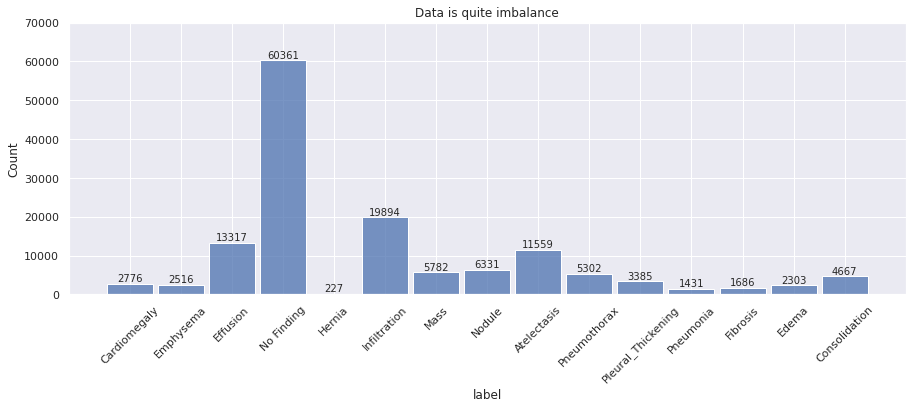

In [5]:
def finding_Labels_p1(df):
    test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')["var1"]
    test = test.reset_index(drop=True).to_frame()
    test.columns = ["label"]

    fig, ax = plt.subplots(figsize=(15,5))
    ax.tick_params(axis='x', rotation=45)
    sns.histplot(test, x="label", discrete=True, ax=ax, shrink=.9).set_title("Data is quite imbalance")
    ax.bar_label(ax.containers[0])
    plt.ylim(0,70000)
    plt.show(sns)

finding_Labels_p1(all_xray_df)

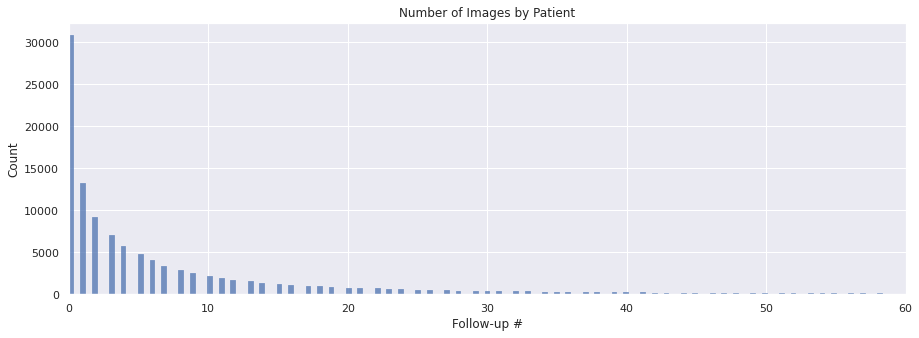

In [6]:
def follow_up_number_p1(df):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.histplot(data=df, x="Follow-up #", ax=ax).set_title('Number of Images by Patient')
    plt.xlim(0,60)
    plt.show(sns)

follow_up_number_p1(all_xray_df)

<AxesSubplot:>

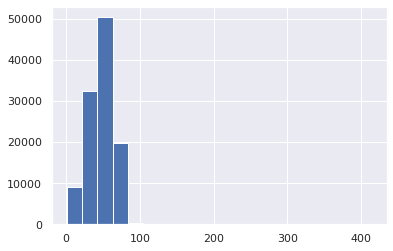

In [7]:
all_xray_df['Patient Age'].hist(bins=20)

In [8]:
all_xray_df = all_xray_df[all_xray_df['Patient Age'] <= 120]

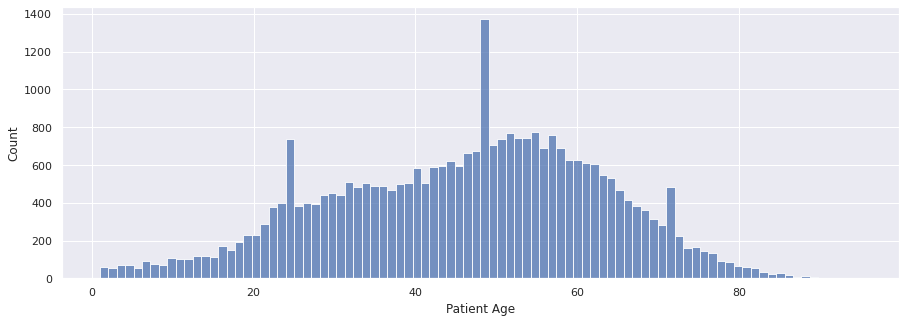

In [9]:
def patient_age_p1(df):
    test = df[df['Patient Age'] <= 120]
    test = df.groupby("Patient ID").agg('first')

    fig, ax = plt.subplots(figsize=(15,5))
    sns.histplot(test, x="Patient Age", ax=ax, bins=90)
    plt.show(sns)

patient_age_p1(all_xray_df)

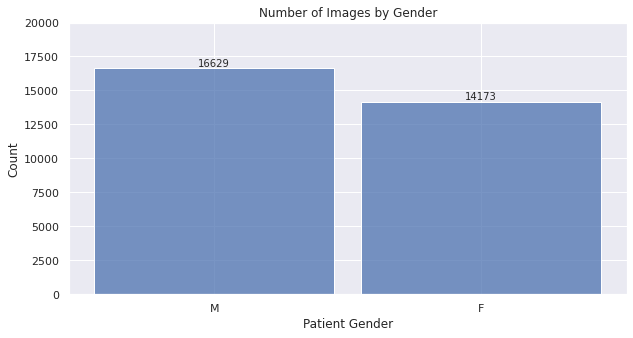

In [10]:
def patient_gender_p1(df):
    #remove duplicate patients
    test = df.groupby("Patient ID").agg('first')

    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(test, x="Patient Gender", discrete=True, ax=ax, shrink=.9).set_title("Number of Images by Gender")
    ax.bar_label(ax.containers[0])
    plt.ylim(0,20000)
    plt.show(sns)
    
patient_gender_p1(all_xray_df)

This variable provides us with the "View" at which the image was taken. The two possible values in this column are PA or AP.

PA - From the back (Posterior to Anterior)

AP - From the front (Anterior to Posterior)

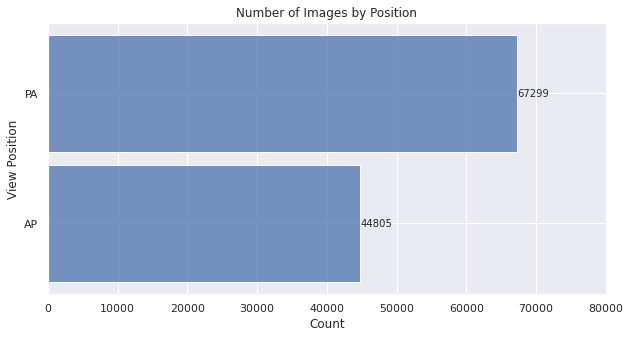

In [11]:
def view_position_p1(df):
    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(df, y='View Position', discrete=True, ax=ax, shrink=.9).set_title("Number of Images by Position")
    ax.bar_label(ax.containers[0])
    plt.xlim(0, 80000)
    plt.show(sns)
    
view_position_p1(all_xray_df)

## Age by Gender

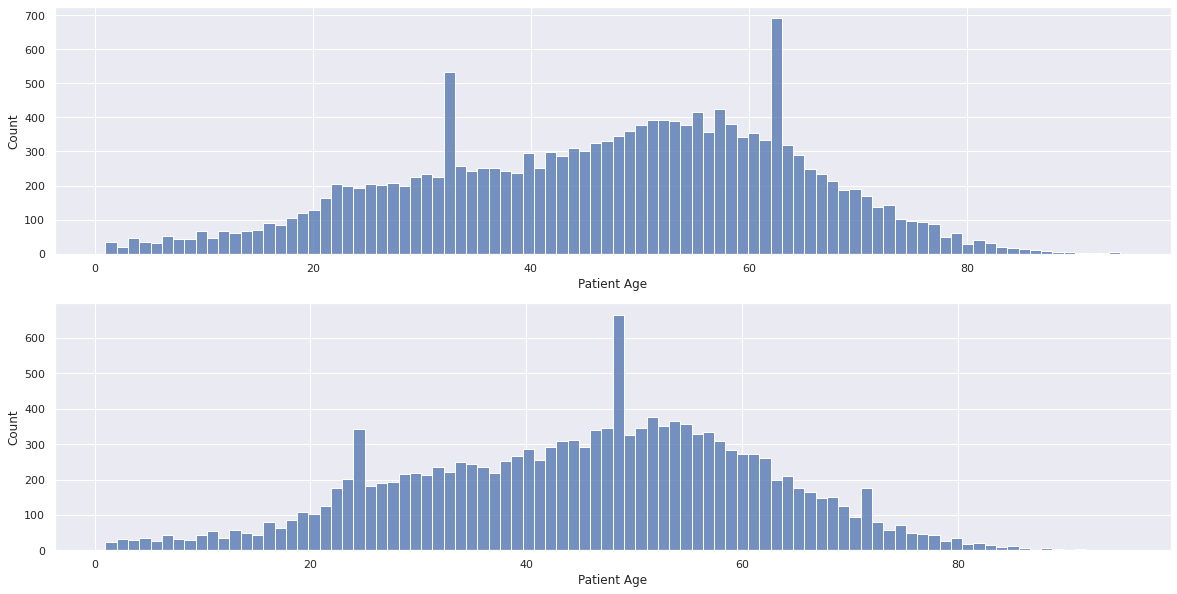

In [12]:
def age_by_gender_p1(df):
    test = df.groupby("Patient ID").agg('first')
    fig, axes = plt.subplots(2,1,figsize=(20,10))

    for i, val in enumerate(["M","F"]):
        test1 = test[test['Patient Gender'] == val].reset_index()
        sns.histplot(test1, x="Patient Age", ax=axes[i], bins=90)

    plt.show(sns)
    
age_by_gender_p1(all_xray_df)

## Distribution of finding Diseaes by Gender

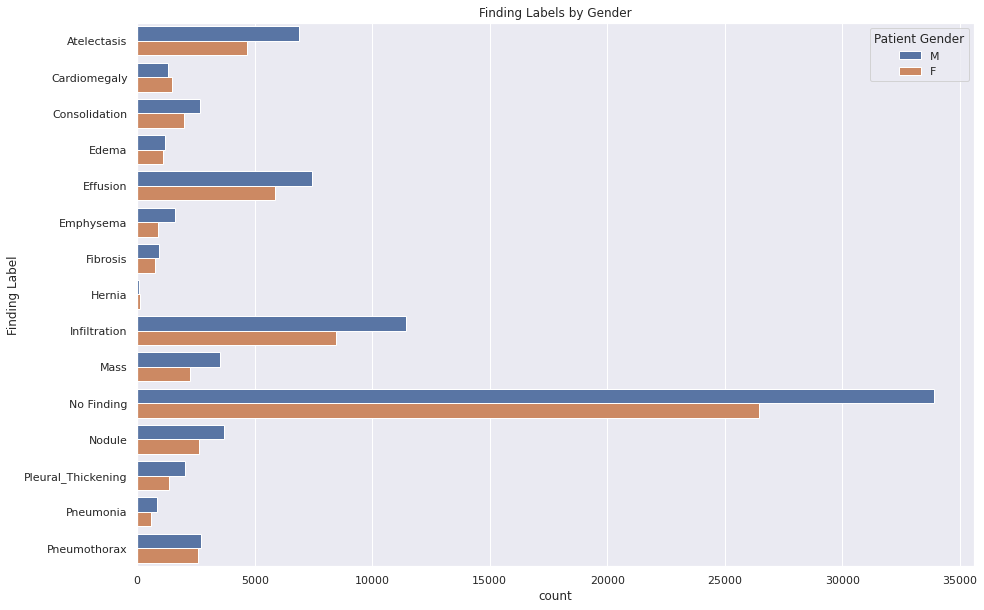

In [13]:
def labels_by_gender_p1(df):
    test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')
    plot_df = pd.DataFrame()

    for val in ["M", "F"]:
        test1 = test[test["Patient Gender"] == val].reset_index(drop=True)
        test1 = test1.groupby("var1").size().sort_index().reset_index(name="count")
        test1["Patient Gender"] = val

        plot_df = pd.concat([plot_df, test1]).reset_index(drop=True)

    plt.figure(figsize=(15, 10))
    plt.title("Finding Labels by Gender")
    ax = sns.barplot(y="var1", hue="Patient Gender", x="count", data=plot_df, orient = 'h')
    plt.ylabel("Finding Label")
    plt.show(sns)

labels_by_gender_p1(all_xray_df)

## Distribution of finding Disease by Age

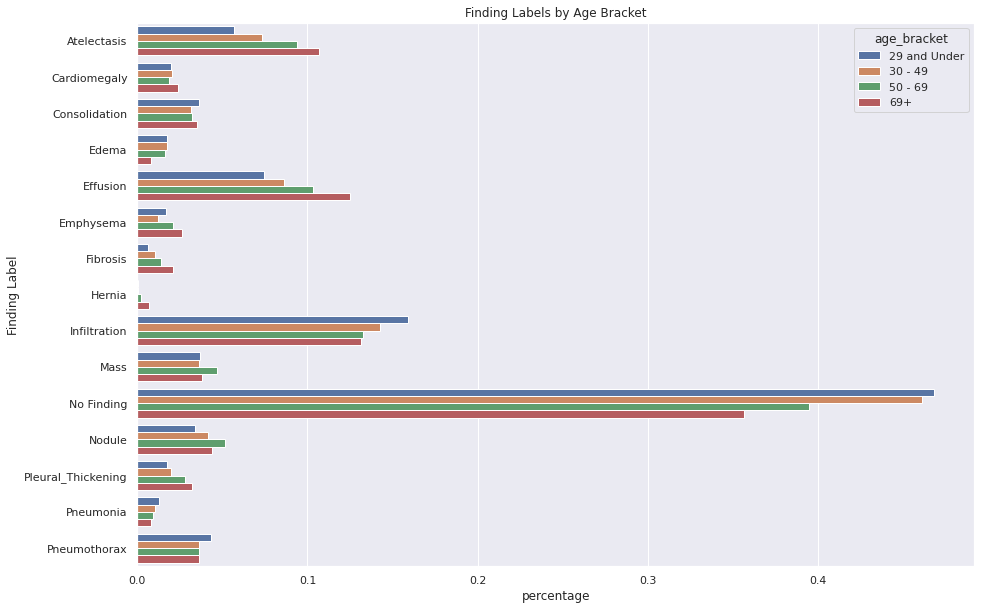

In [14]:
def labels_by_age_p1(df):
    test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')

    conditions = [
        (test['Patient Age'] <= 29),
        (test['Patient Age'] >= 30) & (test['Patient Age'] <= 49),
        (test['Patient Age'] >= 50) & (test['Patient Age'] <= 69),
        (test['Patient Age'] >= 60)
    ]

    choices = ['29 and Under', '30 - 49', '50 - 69', '69+']
    test['age_bracket'] = np.select(conditions, choices, default=np.nan)
    test1 = test.groupby(["age_bracket", "var1"]).size().sort_index().reset_index(name="count")
    test2 = test1.groupby("age_bracket").sum("count").reset_index()

    test1 = test1.merge(test2, on='age_bracket', suffixes=('', '_total'))
    test1["percentage"] = test1["count"]/test1["count_total"]

    plt.figure(figsize=(15, 10))
    plt.title("Finding Labels by Age Bracket")
    ax = sns.barplot(y="var1", hue="age_bracket", x="percentage", data=test1, orient = 'h')
    plt.ylabel("Finding Label")
    plt.show(sns)
    
labels_by_age_p1(all_xray_df)

## Distribution of finding labels by followup

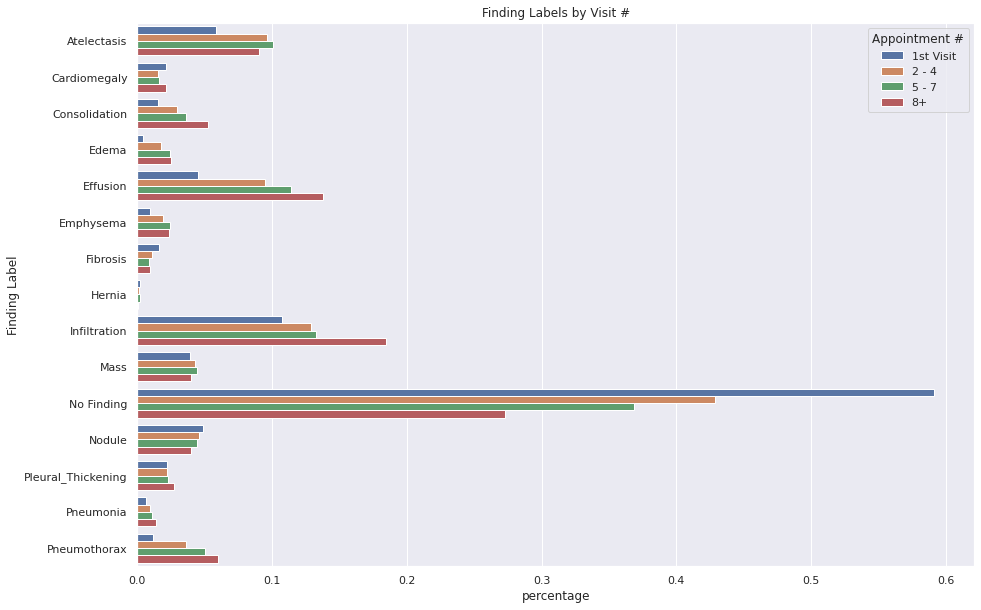

In [15]:
def labels_by_follow_up_p1(df):
    
    test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')

    conditions = [
        (test['Follow-up #'] <= 1),
        (test['Follow-up #'] >= 2) & (test['Follow-up #'] <= 4),
        (test['Follow-up #'] >= 5) & (test['Follow-up #'] <= 7),
        (test['Follow-up #'] >= 8)
    ]

    choices = ['1st Visit', '2 - 4', '5 - 7', '8+']
    test['Appointment #'] = np.select(conditions, choices, default=np.nan)
    test1 = test.groupby(["Appointment #", "var1"]).size().sort_index().reset_index(name="count")
    test2 = test1.groupby("Appointment #").sum("count").reset_index()

    test1 = test1.merge(test2, on='Appointment #', suffixes=('', '_total'))
    test1["percentage"] = test1["count"]/test1["count_total"]

    plt.figure(figsize=(15, 10))
    plt.title("Finding Labels by Visit #")
    ax = sns.barplot(y="var1", hue="Appointment #", x="percentage", data=test1, orient = 'h')
    plt.ylabel("Finding Label")
    plt.show(sns)
    
labels_by_follow_up_p1(all_xray_df)

## Lables with multiple Disease

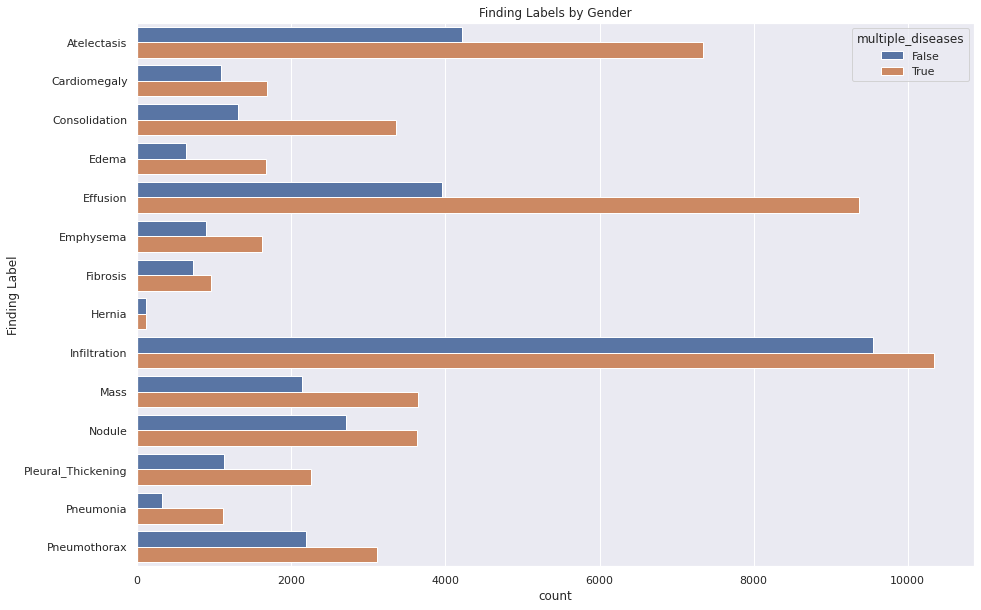

In [16]:
def single_multiple_diseases_p1(df):
    test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')
    test["multiple_diseases"] = test['Finding Labels'].str.match(r'\w+\|\w+') #counting "|" occurances
    test = test[test["Finding Labels"]!="No Finding"]
    test1 = test.groupby(["var1", "multiple_diseases"]).size().sort_index().reset_index(name="count")

    plt.figure(figsize=(15, 10))
    plt.title("Finding Labels by Gender")
    ax = sns.barplot(y="var1", hue="multiple_diseases", x="count", data=test1, orient = 'h')
    plt.ylabel("Finding Label")
    plt.show(sns)
    
single_multiple_diseases_p1(all_xray_df)

## Related labels

In [17]:
import networkx as nx

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


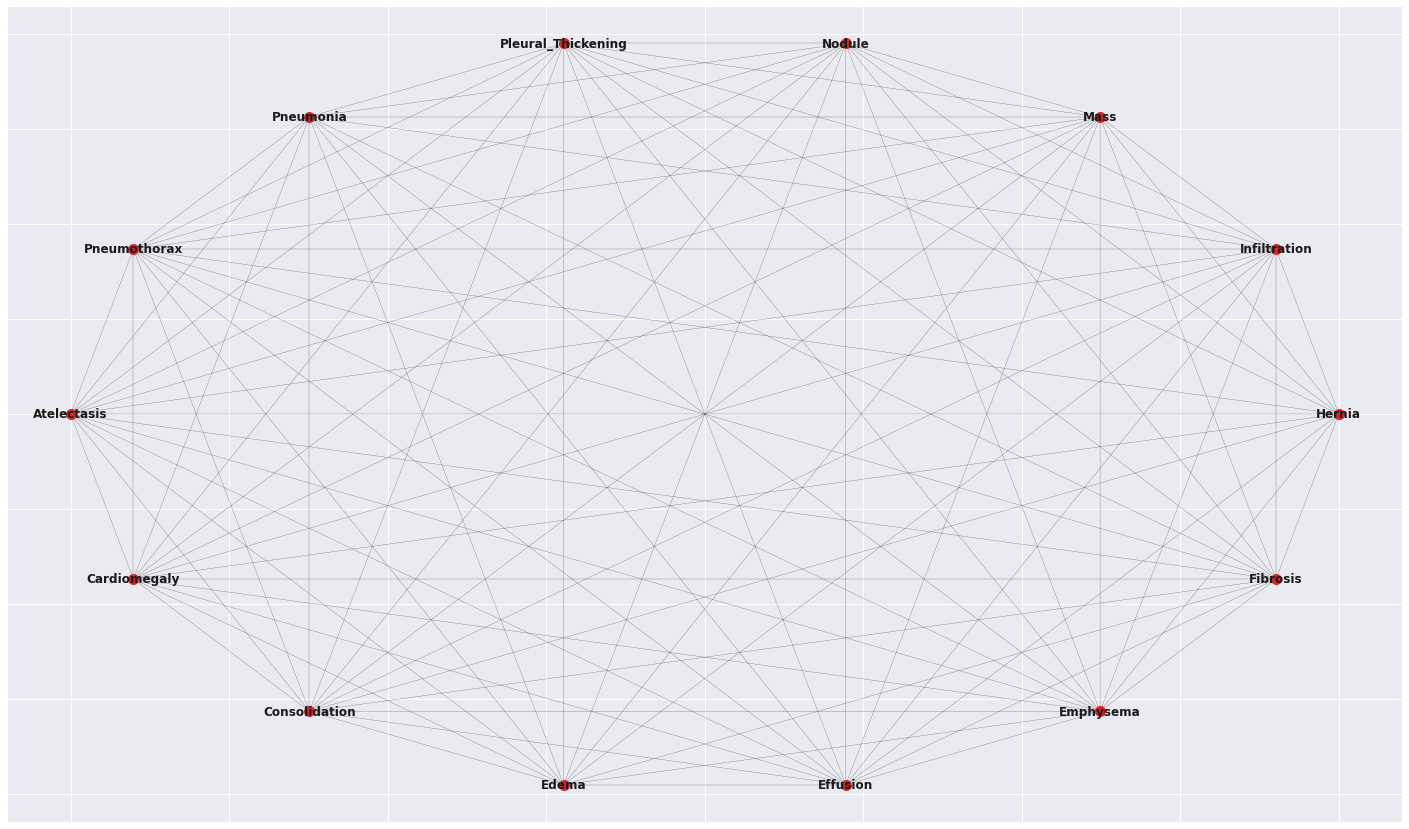

In [18]:
def label_groups_p1(df):
    #preprocessing data
    df = df[df["Finding Labels"].str.count(r'\|') == 1]
    df["tags"] = df["Finding Labels"].str.split("|")
    df["tags"] = df["tags"].apply(lambda x: sorted(x))

    #getting unique labels
    all_tags = np.unique(np.concatenate(df['tags'].values))
    all_tags

    #add edge helper
    def add_edge_weight(head, tail):
        try:
            weight = G[head][tail]['weight']
        except:
            G.add_edge(head, tail, weight=1)
        else:
            G[head][tail]['weight'] += 1

    # initialize graph
    G = nx.Graph()

    # add all nodes (tags)
    for t in all_tags:
        G.add_node(t)

    # add all edges (tags occurring together)
    for q in df.index:
        tags = df.loc[q, 'tags']
        for i in range(len(tags)-1):
            for j in range(i+1, len(tags)):
                add_edge_weight(tags[i], tags[j])

    plt.figure(figsize=(25,15))
    pos = nx.shell_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='tab:red')
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=0.2)
    nx.draw_networkx_labels(G, pos, {n: str(n) for n in list(G.nodes())}, font_weight='bold', font_color='k')
    plt.show()
    
label_groups_p1(all_xray_df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


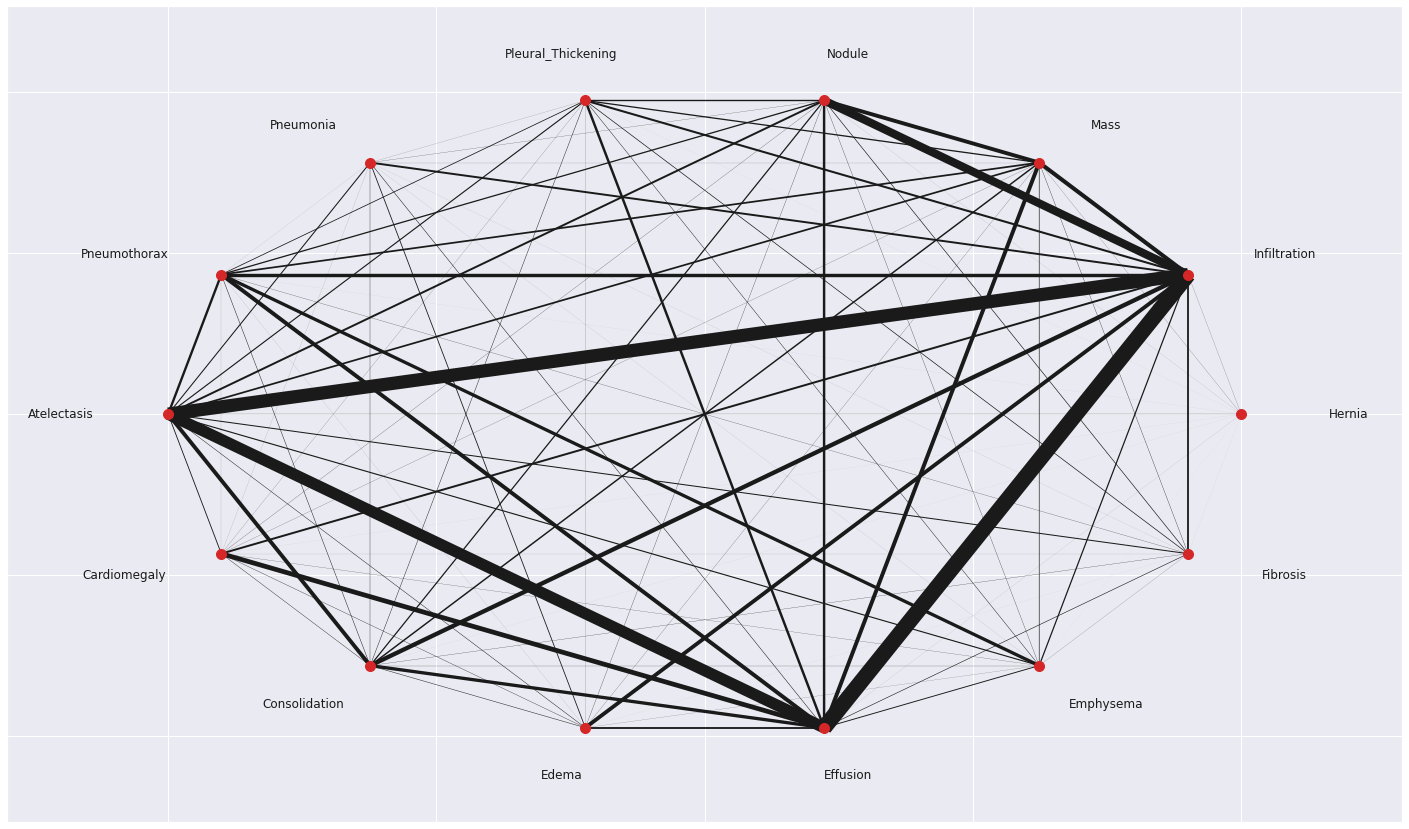

In [19]:
def label_groups_p2(df):
    #preprocessing data
    df = df[df["Finding Labels"].str.count(r'\|') == 1]
    df["tags"] = df["Finding Labels"].str.split("|")
    df["tags"] = df["tags"].apply(lambda x: sorted(x))

    #getting unique labels
    all_tags = np.unique(np.concatenate(df['tags'].values))
    all_tags

    #add edge helper
    def add_edge_weight(head, tail):
        try:
            weight = G[head][tail]['weight']
        except:
            G.add_edge(head, tail, weight=1)
        else:
            G[head][tail]['weight'] += 1

    # initialize graph
    G = nx.Graph()

    # add all nodes (tags)
    for t in all_tags:
        G.add_node(t)

    # add all edges (tags occurring together)
    for q in df.index:
        tags = df.loc[q, 'tags']
        for i in range(len(tags)-1):
            for j in range(i+1, len(tags)):
                add_edge_weight(tags[i], tags[j])

    plt.figure(figsize=(25,15))
    pos = nx.shell_layout(G)

    #calc total weights
    w_sum = 0
    for (node1,node2,data) in G.edges(data=True):
        w_sum += data['weight']

    #draw edges + nodes
    for (node1,node2,data) in G.edges(data=True):
        width = data["weight"]*len(G.nodes)*10.0/w_sum
        nx.draw_networkx_edges(G,pos,edgelist=[(node1, node2)],width=width)

    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='tab:red')

    #draw labels w/ out overlap
    new_pos = {k: np.asarray([v[0]*1.2, v[1]*1.15]) for k, v in pos.items()}
    nx.draw_networkx_labels(G, new_pos, {n: str(n) for n in list(G.nodes())})
    plt.margins(x=0.15, y=0.15)
    plt.show()
    
label_groups_p2(all_xray_df)